# Get Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/PlantSnap/images.zip

Archive:  /content/drive/MyDrive/PlantSnap/images.zip
replace images/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Split

In [5]:
!pip install split-folders

In [6]:
import splitfolders
splitfolders.ratio('/content/images', output="split_images", seed=1337, ratio=(.8,.1,.1))

Copying files: 4327 files [00:00, 4922.62 files/s]


# Import Library

In [7]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import cv2
import pathlib
import pandas as pd
from tensorflow.keras.applications import DenseNet201, MobileNetV3Small, VGG16, EfficientNetB5, InceptionV3, EfficientNetV2M, EfficientNetV2B0, EfficientNetB7, DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.layers import Input
from keras import layers
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Image PreProcessing

In [8]:
base_dir = '/content/split_images'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [9]:
class_names = sorted(os.listdir('/content/split_images/train'))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 5
Classes     : ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [10]:
batch_size = 16


#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen = ImageDataGenerator(
                    rescale=1/255.,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)

val_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)


train_dataset = train_datagen.flow_from_directory(
        train_dir,
        shuffle=True,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

val_dataset = val_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_dataset = val_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 3460 images belonging to 5 classes.
Found 431 images belonging to 5 classes.
Found 436 images belonging to 5 classes.


# Show Random Image

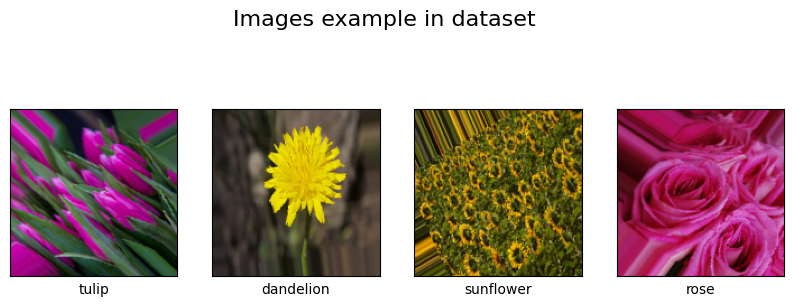

In [11]:
x,y = train_dataset.next()

label = np.argmax(y, axis=1)
fig = plt.figure(figsize=(10,10))
fig.suptitle("Images example in dataset", fontsize=16)
for i in range(4):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[label[i]])
plt.show()

# Transfer Learning using EfficientNetV2M

In [12]:
base_model = EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3),
    pooling=None,
    include_preprocessing=True
)

214201816/214201816 [==============================] - 2s 0us/step


# Fine Tuning

In [13]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [14]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(n_classes, activation='softmax')(x)

In [15]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 75, 75, 24)           648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 75, 75, 24)           96        ['stem_conv[0][0]']           
 n)                                                                                           

In [17]:
# tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [18]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
checkpoint = ModelCheckpoint('best_model_v2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Training Model

In [20]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/50
217/217 [==============================] - ETA: 0s - loss: 1.6565 - accuracy: 0.2040
Epoch 1: val_accuracy improved from -inf to 0.21578, saving model to best_model_v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 163s 340ms/step - loss: 1.6565 - accuracy: 0.2040 - val_loss: 1.5970 - val_accuracy: 0.2158 - lr: 1.0000e-04
Epoch 2/50
217/217 [==============================] - ETA: 0s - loss: 1.5919 - accuracy: 0.2610
Epoch 2: val_accuracy improved from 0.21578 to 0.39211, saving model to best_model_v2.h5
217/217 [==============================] - 64s 296ms/step - loss: 1.5919 - accuracy: 0.2610 - val_loss: 1.5109 - val_accuracy: 0.3921 - lr: 1.0000e-04
Epoch 3/50
217/217 [==============================] - ETA: 0s - loss: 1.5355 - accuracy: 0.3153
Epoch 3: val_accuracy did not improve from 0.39211
217/217 [==============================] - 60s 275ms/step - loss: 1.5355 - accuracy: 0.3153 - val_loss: 1.5356 - val_accuracy: 0.3318 - lr: 1.0000e-04
Epoch 4/50
217/217 [==============================] - ETA: 0s - loss: 1.4841 - accuracy: 0.3772
Epoch 4: val_accuracy improved from 0.39211 to 0.48724, saving model to best_model_v2.h5
217/217 [====================

# Model Evaluation

In [21]:
model.evaluate(test_dataset,batch_size=16)
y_pred=model.predict(test_dataset)
y_pred=np.argmax(y_pred,axis=1)
accuracy_score(y_pred,test_dataset.classes)
print(classification_report(y_pred,test_dataset.classes))

28/28 [==============================] - 7s 82ms/step
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        74
           1       0.94      0.90      0.92       111
           2       0.94      0.76      0.84        98
           3       0.92      0.94      0.93        72
           4       0.76      0.93      0.83        81

    accuracy                           0.89       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.89      0.89      0.89       436



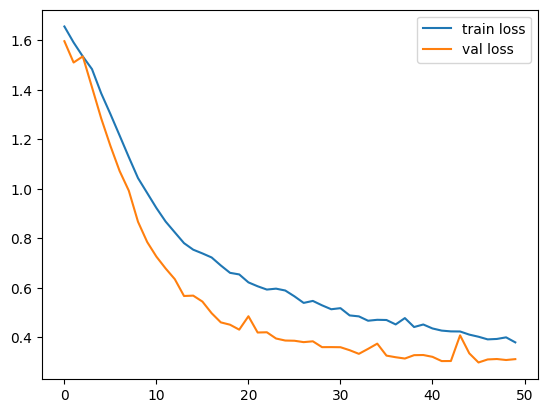

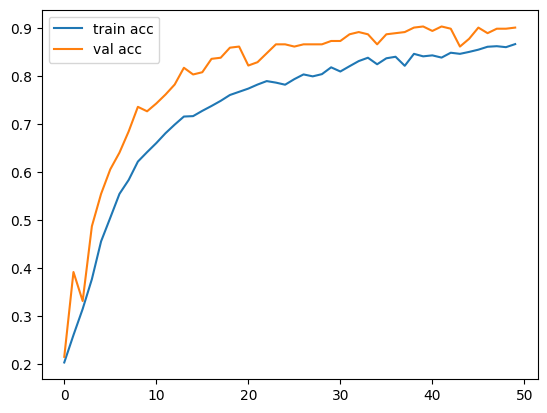

In [22]:
def report_train(history):
    # loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    # accuracies
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

report_train(history)

# Testing model using new data

In [26]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    preds = model.predict(img)
    class_labels = class_names
    pred = np.argmax(preds, axis=-1)
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(class_labels[pred[0]])
        plt.show()

1/1 [==============================] - 5s 5s/step


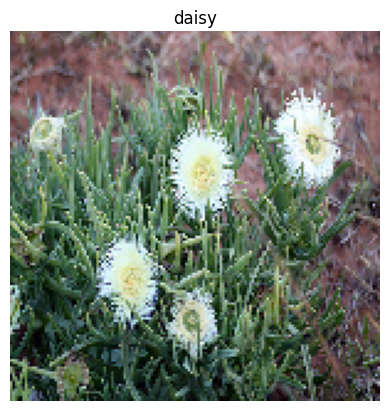

1/1 [==============================] - 0s 43ms/step


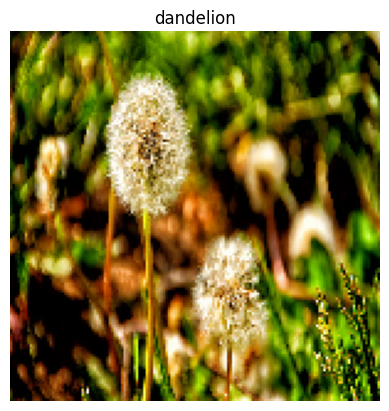

1/1 [==============================] - 0s 54ms/step


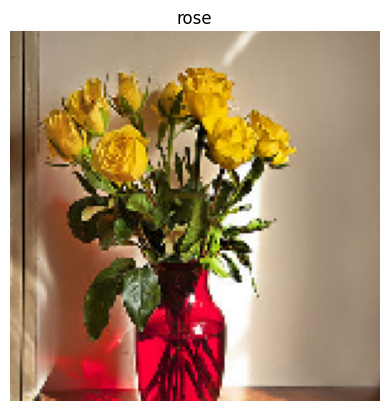

1/1 [==============================] - 0s 40ms/step


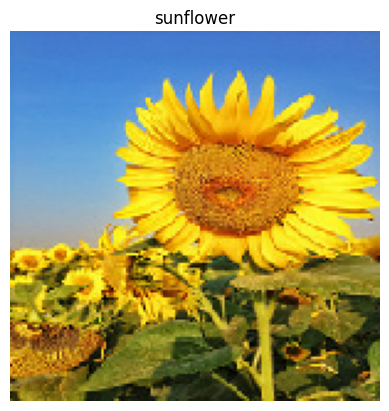

1/1 [==============================] - 0s 42ms/step


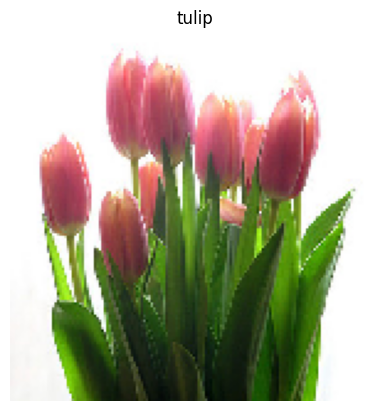

In [27]:
images = []

images.append('/content/split_images/test/daisy/10466290366_cc72e33532.jpg')
images.append('/content/split_images/test/dandelion/10778387133_9141024b10.jpg')
images.append('/content/split_images/test/rose/12238827553_cf427bfd51_n.jpg')
images.append('/content/split_images/test/sunflower/10541580714_ff6b171abd_n.jpg')
images.append('/content/split_images/test/tulip/112428665_d8f3632f36_n.jpg')

predict_class(model, images, show = True)

# Saving Model TF.Lite

In [28]:
export_dir = 'saved_model/PlantSnap_EfficientNetV2M/'
tf.saved_model.save(model, export_dir)

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [30]:
tflite_model_file = pathlib.Path('PlantSnap_Model_EfficientNetV2M.tflite')
tflite_model_file.write_bytes(tflite_model)

212395700

# Saving Model TF.JS

# Save History

In [ ]:
# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)
path = 'history/'

# Check if the directory exists, if not, create it
if not os.path.exists(path):
    os.makedirs(path)

# csv:
hist_csv_file = 'PlantSnap_Model_densenet121.csv'
with open(os.path.join(path, hist_csv_file), mode='w') as f:
    hist_df.to_csv(f, index=False)